# XGBoost 모델

Boost모델 중 Gradient Boosting의 일종으로 회귀, 분류 문제에 모두 사용 가능 <br>
Boost모델 : 이전 모델의 오류를 고려하여 다음 모델이 순차적으로 학습됨 (vs Bagging - random forest) <br>
Boost모델 장점 : Bias 감소, 과소적합 해결 <br>
Gradient Boosting : 틀린 데이터에 집중하기 위해, 가중 샘플링을 하는 대신 잔차 학습




### 특성 정리 <br>

gender : 성별 <br>
home_location : 지역위치 <br>
first_join_date : 처음 가입 날짜 <br>
age_segment : 나이 그룹 <br>
RFM_Segment : RFM 그룹 <br>
low : 하위 10% 로 구매한 비율 <br>
high : 상위 10% 로 구매한 비율 <br>
book_cnt : 구매 횟수 <br>
time / event : 이벤트 평균 길이(s) <br>
add_book_mean : add_to_cart 에서 booking 사이에 평균 시간 (days) <br>
revisit : 평균 재방문 주기 <br> 
session_cnt : 방문횟수(session 수) <br> 
add_last_event_ratio : add_to_cart 로 끝나는 세션의 비율 <br> 
promo_use_ratio : 프로모션 적용한 구매 비율 <br> 
average_revenue : 세션당 객단가 <br> 
churn : 이탈 여부 (target)

In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from category_encoders import OneHotEncoder
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta
pd.options.display.float_format = '{:.2f}'.format


In [89]:
base_path = os.getcwd()
df = pd.read_csv(base_path + '/feature_target.csv')
df.rename(columns={'bounce':'churn'}, inplace=True)
df = df.iloc[:,1:]
df.head()

,gender,home_location,first_join_date,age_segment,RFM_Segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,churn
0,M,Nusa Tenggara Barat,2020-08-23,Early 30s(31-35),322.00,0.14,0.07,89,104.58,1.67,0 days 17:06:10.890688259,989,0.06,0.20,537850.17,1
1,M,Kalimantan Selatan,2021-04-11,Early 20s(21-25),111.00,1.00,0.00,1,108.30,0.00,0,1,0.00,0.00,115702.00,1
2,F,Bengkulu,2022-01-09,minor(15-20),211.00,0.00,0.00,2,260.64,2.80,10 days 05:37:20.600000,11,0.36,0.50,190362.00,1
3,F,Jawa Barat,2019-09-12,Late 20s(26-30),111.00,0.50,0.25,3,311.72,5.75,43 days 21:52:05.125000,17,0.24,1.00,770944.33,1
4,F,Yogyakarta,2019-11-21,Late 20s(26-30),111.00,0.33,0.00,3,261.24,24.36,46 days 21:04:21.714285714,15,0.33,0.67,163779.00,1


## 모델 1. 모든 특성 사용

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50699 entries, 0 to 50698
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                50699 non-null  object 
 1   home_location         50699 non-null  object 
 2   first_join_date       50699 non-null  object 
 3   age_segment           50699 non-null  object 
 4   RFM_Segment           50699 non-null  float64
 5   low                   50699 non-null  float64
 6   high                  50699 non-null  float64
 7   book_cnt              50699 non-null  int64  
 8   time/event            50699 non-null  float64
 9   add_book_mean         50699 non-null  float64
 10  revisit               50699 non-null  object 
 11  session_cnt           50699 non-null  int64  
 12  add_last_event_ratio  50699 non-null  float64
 13  promo_use_ratio       50699 non-null  float64
 14  average_revenue       50699 non-null  float64
 15  churn              

In [91]:
# 시계열 데이터 어떻게 사용...?
df.drop('first_join_date', axis=1, inplace=True)

In [92]:
# revisit(재방문 주기) : 초로 나타내서 int로 표현
df['revisit'] = pd.to_timedelta(df['revisit']).dt.total_seconds()
df['revisit']

0         61570.89
1             0.00
2        884240.60
3       3793925.12
4       4050261.71
           ...    
50694   3550304.97
50695     96020.15
50696    381335.17
50697     96734.76
50698    197581.78
Name: revisit, Length: 50699, dtype: float64

In [93]:
df['RFM_Segment'] = df['RFM_Segment'].astype('int').astype('str')

In [94]:
# 타겟 불균형 확인
df.churn.value_counts()

1    41851
0     8848
Name: churn, dtype: int64

In [95]:
# 타겟 설정
target = 'churn'

# 학습/테스트 데이터 분리
train, val = train_test_split(df, train_size=0.8, stratify=df['churn'], random_state=2)
val, test = train_test_split(val, train_size=0.8, stratify=val['churn'], random_state=2)
print(train.shape)
print(val.shape)
print(test.shape)

(40559, 15)
(8112, 15)
(2028, 15)


In [96]:
# feature, target 분리
def split_x_y(df):
    x,y = df.drop(target, axis=1), df[target]
    return x,y

X_train, y_train = split_x_y(train)
X_val, y_val = split_x_y(val)
X_test, y_test = split_x_y(test)

In [97]:
encoding_cols = ['gender', 'home_location', 'age_segment', 'RFM_Segment']
pipe = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc", 
        n_estimators=50,
        random_state=2,
        n_jobs=-1,
        max_depth=7,
        learning_rate=0.1,
        scale_pos_weight= len(df[df['churn'] == 0]) / len(df[df['churn'] == 1])
    ),
)
print(pipe)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimator

In [98]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'home_location', 'age_segment',
                                     'RFM_Segment'])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=2, ...))])

In [99]:
# train 학습, 검증셋 정확도
print("학습 정확도", pipe.score(X_train, y_train))
print("검증 정확도", pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)
print("ROC_AUC_score", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

학습 정확도 0.6638477280011834
검증 정확도 0.5608974358974359
ROC_AUC_score 0.503475386266529
              precision    recall  f1-score   support

           0       0.18      0.42      0.25      1416
           1       0.83      0.59      0.69      6696

    accuracy                           0.56      8112
   macro avg       0.50      0.50      0.47      8112
weighted avg       0.71      0.56      0.61      8112



<Axes: >

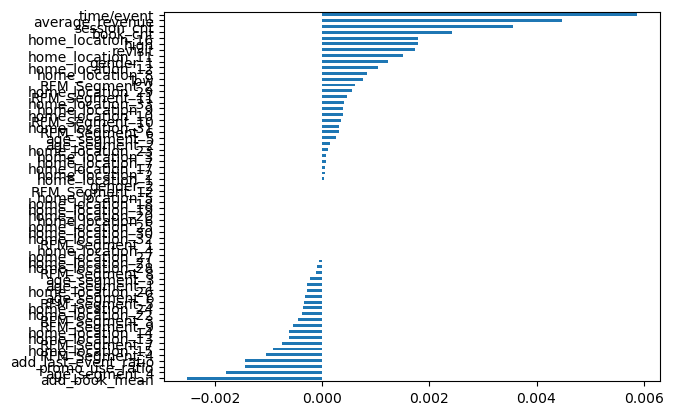

In [110]:
# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps["xgbclassifier"],  # model
    scoring="roc_auc",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

# 스코어를 다시 계산합니다.
X_val_preprocessed = pipe[0].transform(X_val)
permuter.fit(X_val_preprocessed, y_val)

feature_names = X_val_preprocessed.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()

In [113]:
# 특성별 score을 확인합니다.
eli5.show_weights(
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0059 ± 0.0071,time/event
0.0045 ± 0.0049,average_revenue
0.0036 ± 0.0063,session_cnt
0.0024 ± 0.0063,book_cnt
0.0018 ± 0.0008,home_location_16
0.0018 ± 0.0045,high
0.0017 ± 0.0087,revisit
0.0015 ± 0.0040,home_location_11
0.0012 ± 0.0030,gender_1
0.0010 ± 0.0032,home_location_12


## 모델 2. RFM 그룹 제외

In [ ]:
df2 = df.copy()
df2.drop('RFM_Segment', axis=1, inplace=True)
df2.head()

,gender,home_location,age_segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,churn
0,M,Nusa Tenggara Barat,Early 30s(31-35),0.14,0.07,89,104.58,1.67,61570.89,989,0.06,0.20,537850.17,1
1,M,Kalimantan Selatan,Early 20s(21-25),1.00,0.00,1,108.30,0.00,0.00,1,0.00,0.00,115702.00,1
2,F,Bengkulu,minor(15-20),0.00,0.00,2,260.64,2.80,884240.60,11,0.36,0.50,190362.00,1
3,F,Jawa Barat,Late 20s(26-30),0.50,0.25,3,311.72,5.75,3793925.12,17,0.24,1.00,770944.33,1
4,F,Yogyakarta,Late 20s(26-30),0.33,0.00,3,261.24,24.36,4050261.71,15,0.33,0.67,163779.00,1


In [ ]:
# 타겟 설정
target = 'churn'

# 학습/테스트 데이터 분리
train2, val2 = train_test_split(df2, train_size=0.8, stratify=df2['churn'], random_state=2)
val2, test2 = train_test_split(val2, train_size=0.8, stratify=val2['churn'], random_state=2)
print(train2.shape)
print(val2.shape)
print(test2.shape)

(40559, 14)
(8112, 14)
(2028, 14)


In [ ]:
# feature, target 분리
def split_x_y(df):
    x,y = df.drop(target, axis=1), df[target]
    return x,y

X_train2, y_train2 = split_x_y(train2)
X_val2, y_val2 = split_x_y(val2)
X_test2, y_test2 = split_x_y(test2)

In [ ]:
encoding_cols = ['gender', 'home_location', 'age_segment']
pipe2 = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc", 
        n_estimators=50,
        random_state=2,
        n_jobs=-1,
        max_depth=7,
        learning_rate=0.1,
        scale_pos_weight= len(df[df['churn'] == 0]) / len(df[df['churn'] == 1])
    ),
)
print(pipe2)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimator

In [ ]:
pipe2.fit(X_train2, y_train2)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'home_location',
                                     'age_segment'])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=2, ...))])

In [ ]:
# train 학습, 검증셋 정확도
print("학습 정확도", pipe2.score(X_train2, y_train2))
print("검증 정확도", pipe2.score(X_val2, y_val2))
y_pred2 = pipe2.predict(X_val2)
print("ROC_AUC_score", roc_auc_score(y_val2, y_pred2))
print(classification_report(y_val2, y_pred2))

학습 정확도 0.6638477280011834
검증 정확도 0.5708826429980276
ROC_AUC_score 0.510915952858271
              precision    recall  f1-score   support

           0       0.18      0.42      0.25      1416
           1       0.83      0.60      0.70      6696

    accuracy                           0.57      8112
   macro avg       0.51      0.51      0.48      8112
weighted avg       0.72      0.57      0.62      8112



## 모델 3. RFM_Segment, Home Location 제외 -> ROC_AUC score가 0.5 아래로 떨어짐

In [ ]:
df3 = df.copy()
df3.drop(['RFM_Segment','home_location'], axis=1, inplace=True)
df3.head()

,gender,age_segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,churn
0,M,Early 30s(31-35),0.14,0.07,89,104.58,1.67,61570.89,989,0.06,0.20,537850.17,1
1,M,Early 20s(21-25),1.00,0.00,1,108.30,0.00,0.00,1,0.00,0.00,115702.00,1
2,F,minor(15-20),0.00,0.00,2,260.64,2.80,884240.60,11,0.36,0.50,190362.00,1
3,F,Late 20s(26-30),0.50,0.25,3,311.72,5.75,3793925.12,17,0.24,1.00,770944.33,1
4,F,Late 20s(26-30),0.33,0.00,3,261.24,24.36,4050261.71,15,0.33,0.67,163779.00,1


In [103]:
# 타겟 설정
target = 'churn'

# 학습/테스트 데이터 분리
train3, val3 = train_test_split(df3, train_size=0.8, stratify=df3['churn'], random_state=2)
val3, test3 = train_test_split(val3, train_size=0.8, stratify=val3['churn'], random_state=2)
print(train3.shape)
print(val3.shape)
print(test3.shape)

(40559, 13)
(8112, 13)
(2028, 13)


In [104]:
X_train3, y_train3 = split_x_y(train3)
X_val3, y_val3 = split_x_y(val3)
X_test3, y_test3 = split_x_y(test3)

In [117]:
encoding_cols = ['gender', 'home_location', 'age_segment']
pipe3 = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc", 
        n_estimators=50,
        random_state=2,
        n_jobs=-1,
        max_depth=7,
        learning_rate=0.1,
        scale_pos_weight= len(df[df['churn'] == 0]) / len(df[df['churn'] == 1])
    ),
)
print(pipe3)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimator

In [118]:
pipe3.fit(X_train3, y_train3)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'age_segment'])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=2, ...))])

In [119]:
# train 학습, 검증셋 정확도
print("학습 정확도", pipe3.score(X_train3, y_train3))
print("검증 정확도", pipe3.score(X_val3, y_val3))
y_pred3 = pipe3.predict(X_val3)
print("ROC_AUC_score", roc_auc_score(y_val3, y_pred3))
print(classification_report(y_val3, y_pred3))

학습 정확도 0.6640942824034123
검증 정확도 0.5659516765285996
ROC_AUC_score 0.49651322317396673
              precision    recall  f1-score   support

           0       0.17      0.39      0.24      1416
           1       0.82      0.60      0.70      6696

    accuracy                           0.57      8112
   macro avg       0.50      0.50      0.47      8112
weighted avg       0.71      0.57      0.62      8112

